# Phase 2: KPI Monitoring and Early Anomaly Detection for Wind Turbine Performance

When I started Phase 2, my goal was to move from raw SCADA signals to something that really tells me about the turbine’s performance.  
I decided to create a simple KPI — the power-to-wind-speed ratio — because it directly shows how efficiently the turbine converts wind into electricity.  
I knew that not all data points are meaningful, so I filtered out low-wind conditions where zero power is expected; otherwise, the KPI could be misleading.

Next, I used rolling mean and standard deviation to smooth out short-term noise and focus on gradual trends.  
Applying Z-score-based anomaly detection helped me spot times when the turbine wasn’t performing as expected. I even added IQR as an optional check to validate anomalies from another perspective.

Working through this, I realized that visualizing the KPI and anomalies over time is essential — it makes patterns obvious and helps me tell a story about the turbine’s health.  
Overall, this phase taught me how to isolate turbine-specific deviations from environmental effects and provides a foundation for early fault detection.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load cleaned SCADA data
df = pd.read_csv(r"C:\Users\Aria\Project_SCADA\data\scada_clean.csv")

In [3]:
df.head()

,asset_id,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,...,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg,wind_bin,upper_limit,lower_limit,power_anomaly,power_roll_mean,power_roll_std
0,0,0,22.0,302.9,129.4,1.7,1.7,11.7,0.5,0.7,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
1,0,0,22.0,307.1,133.6,1.7,1.7,8.3,0.4,0.7,...,0.0,0.0,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
2,0,0,22.0,340.6,167.1,0.9,0.9,5.9,0.4,0.4,...,0.0,0.0,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
3,0,0,22.0,124.4,-49.1,1.5,1.5,7.1,0.6,0.3,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
4,0,0,22.0,66.2,-107.3,1.0,1.0,2.1,0.4,0.3,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN


In [4]:
df.columns

Index(['asset_id', 'status_type_id', 'sensor_0_avg', 'sensor_1_avg',
       'sensor_2_avg', 'wind_speed_3_avg', 'wind_speed_4_avg',
       'wind_speed_3_max', 'wind_speed_3_min', 'wind_speed_3_std',
       'sensor_5_avg', 'sensor_5_max', 'sensor_5_min', 'sensor_5_std',
       'sensor_6_avg', 'sensor_7_avg', 'sensor_8_avg', 'sensor_9_avg',
       'sensor_10_avg', 'sensor_11_avg', 'sensor_12_avg', 'sensor_13_avg',
       'sensor_14_avg', 'sensor_15_avg', 'sensor_16_avg', 'sensor_17_avg',
       'sensor_18_avg', 'sensor_18_max', 'sensor_18_min', 'sensor_18_std',
       'sensor_19_avg', 'sensor_20_avg', 'sensor_21_avg', 'sensor_22_avg',
       'sensor_23_avg', 'sensor_24_avg', 'sensor_25_avg', 'sensor_26_avg',
       'reactive_power_27_avg', 'reactive_power_27_max',
       'reactive_power_27_min', 'reactive_power_27_std',
       'reactive_power_28_avg', 'reactive_power_28_max',
       'reactive_power_28_min', 'reactive_power_28_std', 'power_29_avg',
       'power_29_max', 'power_29_min', '

In [5]:
# Select only relevant columns

df_healthy = df[['wind_speed_3_avg', 'power_29_avg', 'power_anomaly']].copy()
df.rename(columns={'wind_speed_3_avg':'WindSpeed', 'power_29_avg':'Power'}, inplace=True)
df.head()

,asset_id,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,WindSpeed,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,...,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg,wind_bin,upper_limit,lower_limit,power_anomaly,power_roll_mean,power_roll_std
0,0,0,22.0,302.9,129.4,1.7,1.7,11.7,0.5,0.7,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
1,0,0,22.0,307.1,133.6,1.7,1.7,8.3,0.4,0.7,...,0.0,0.0,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
2,0,0,22.0,340.6,167.1,0.9,0.9,5.9,0.4,0.4,...,0.0,0.0,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
3,0,0,22.0,124.4,-49.1,1.5,1.5,7.1,0.6,0.3,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN
4,0,0,22.0,66.2,-107.3,1.0,1.0,2.1,0.4,0.3,...,0.0,0.0,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN


In [6]:
# Check for missing values

df.isna().sum().sum()

396

# Define Healthy Data

In [7]:
# Take the first 30% of data as initial healthy baseline

df_healthy = df.iloc[:int(len(df)*0.3)]

In [8]:
len(df_healthy)

16495

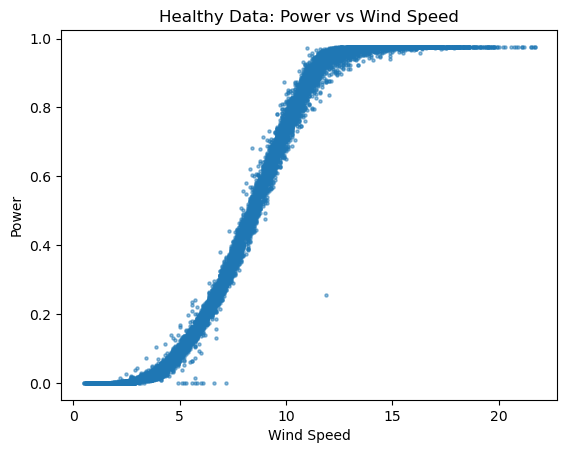

In [9]:
# Visual check of healthy data

plt.scatter(df_healthy['WindSpeed'], df_healthy['Power'], s=5, alpha=0.5)
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.title('Healthy Data: Power vs Wind Speed')
plt.show()

In [10]:
#test to be healthy data, in this column healthy data ere 0 and anomaly data rae 1
df_healthy['power_anomaly'].sum()

5473

In [11]:
df_healthy[['WindSpeed','Power']].describe()


,WindSpeed,Power
count,16495.000000,16495.000000
mean,6.459157,0.309288
std,4.050285,0.360162
min,0.500000,0.000000
25%,3.200000,0.011659
50%,5.400000,0.122537
75%,9.100000,0.607512
max,21.700000,0.975610


In [12]:
# we only consider healthy data (anomaly = 0)
df_healthy = df_healthy[df_healthy['power_anomaly'] == 0]


# Polynomial Fit for Power Curve

In [13]:
# Fit a simple polynomial (degree 3) to model expected power
coeffs = np.polyfit(df_healthy['WindSpeed'], df_healthy['Power'], deg=3)
poly = np.poly1d(coeffs)

# Predict expected power
df_healthy['Power_expected'] = poly(df_healthy['WindSpeed'])

# Calculate residuals (Power_actual - Power_expected)
df_healthy['Residual'] = df_healthy['Power'] - df_healthy['Power_expected']
                                                        
df_healthy.head()

,asset_id,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,WindSpeed,wind_speed_4_avg,wind_speed_3_max,wind_speed_3_min,wind_speed_3_std,...,sensor_52_std,sensor_53_avg,wind_bin,upper_limit,lower_limit,power_anomaly,power_roll_mean,power_roll_std,Power_expected,Residual
0,0,0,22.0,302.9,129.4,1.7,1.7,11.7,0.5,0.7,...,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN,-0.013900,0.013949
1,0,0,22.0,307.1,133.6,1.7,1.7,8.3,0.4,0.7,...,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN,-0.013900,0.013900
2,0,0,22.0,340.6,167.1,0.9,0.9,5.9,0.4,0.4,...,0.0,25.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN,0.006063,-0.006063
3,0,0,22.0,124.4,-49.1,1.5,1.5,7.1,0.6,0.3,...,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN,-0.011192,0.011192
4,0,0,22.0,66.2,-107.3,1.0,1.0,2.1,0.4,0.3,...,0.0,26.0,"(0.475, 1.75]",NaN,NaN,False,NaN,NaN,0.002206,-0.002206


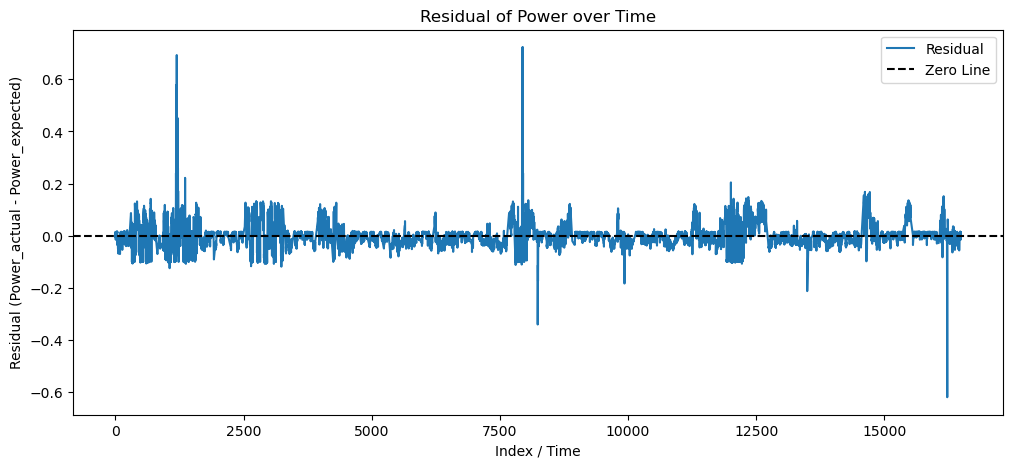

In [14]:
# Plot residuals to highlight deviations

plt.figure(figsize=(12,5))
plt.plot(df_healthy.index, df_healthy['Residual'], label='Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Line')
plt.xlabel('Index / Time')
plt.ylabel('Residual (Power_actual - Power_expected)')
plt.title('Residual of Power over Time')
plt.legend()
plt.show()


Residuals highlight deviations from expected power and indicate potential early faults. By calculating residuals, we remove environmental effects and focus on turbine-specific deviations.

# Define Operational KPI

In [15]:
## Define a simple KPI: power-to-wind-speed ratio
df['power_wind_ratio'] = df['Power'] / df['WindSpeed']
df['power_wind_ratio']

0        0.000029
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
54981    0.000000
54982    0.000000
54983    0.000000
54984    0.000000
54985    0.000000
Name: power_wind_ratio, Length: 54986, dtype: float64

#### If wind speed remains high while the power-to-wind ratio drops, it indicates reduced conversion efficiency, which often points to mechanical or operational issues.

In [16]:
df['power_wind_ratio'].describe()

count    54986.000000
mean         0.032849
std          0.029254
min          0.000000
25%          0.004282
50%          0.025362
75%          0.062271
max          0.095733
Name: power_wind_ratio, dtype: float64

# Wind turbine operating regions:
 1. Cut-in region (low wind speed):
    Wind is present but turbine produces little or no power.
    Power-to-wind ratio is naturally close to zero.

 2. Normal operation (power ramp-up region):
    Turbine efficiently converts wind energy to electrical power.
    Power-to-wind ratio is meaningful in this region.

 3. Rated / high wind region:
    Power output is capped at rated value.
    Power-to-wind ratio may stop increasing or slightly decrease.


### Wind speed thresholds are chosen based on typical turbine cut-in and rated operating regions, not arbitrarily.

In [17]:
## Filter low-wind periods (<3 m/s)
df_op = df.loc[df['WindSpeed'] > 3].copy()
df_op['power_wind_ratio'].describe()


count    43621.000000
mean         0.041276
std          0.027110
min          0.000000
25%          0.015152
50%          0.039096
75%          0.068214
max          0.095733
Name: power_wind_ratio, dtype: float64

Filter applied to focus on operational wind speeds. This removes low-wind periods where power production is physically expected to be zero and ensures KPI reflects turbine performance rather than environmental limitations.


In [18]:
# Calculate rolling statistics to monitor trends
df_op.loc[:, 'kpi_roll_mean'] = df_op['power_wind_ratio'].rolling(window=144).mean()
df_op.loc[:, 'kpi_roll_std']  = df_op['power_wind_ratio'].rolling(window=144).std()


KPI shows turbine efficiency; filtering ensures zero power in low wind does not distort analysis.

In [19]:
# Z-score based anomaly detection

df_op['kpi_zscore'] = (
    df_op['power_wind_ratio'] - df_op['kpi_roll_mean']
) / df_op['kpi_roll_std']

df_op['kpi_anomaly'] = df_op['kpi_zscore'].abs() > 3


In [20]:
# Optional: IQR-based anomaly detection
Q1 = df_op['power_wind_ratio'].quantile(0.25)
Q3 = df_op['power_wind_ratio'].quantile(0.75)
IQR = Q3 - Q1
df_op['kpi_anomaly_iqr'] = ((df_op['power_wind_ratio'] < Q1 - 1.5*IQR) | 
                            (df_op['power_wind_ratio'] > Q3 + 1.5*IQR))


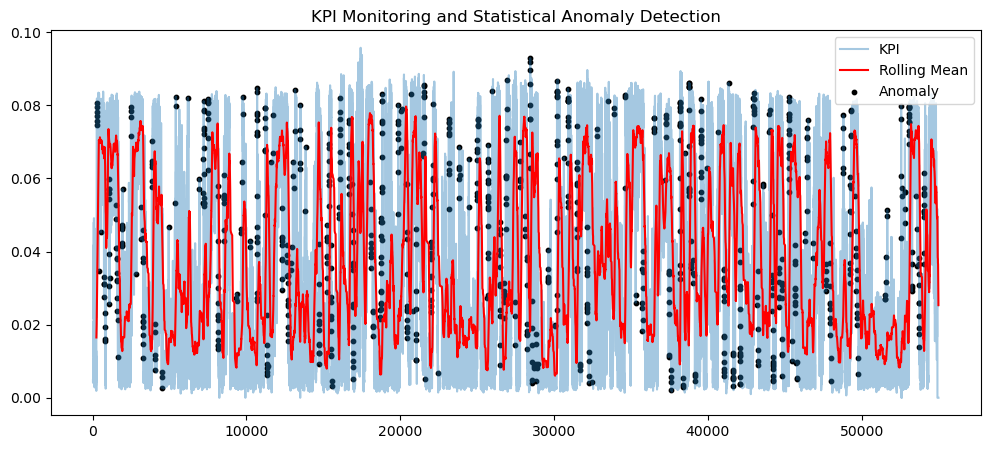

In [21]:
# Plot KPI and anomalies
plt.figure(figsize=(12,5))
plt.plot(df_op.index, df_op['power_wind_ratio'], alpha=0.4, label='KPI')
plt.plot(df_op.index, df_op['kpi_roll_mean'], color='red', label='Rolling Mean')
plt.scatter(
    df_op[df_op['kpi_anomaly']].index,
    df_op[df_op['kpi_anomaly']]['power_wind_ratio'],
    color='black',
    s=10,
    label='Anomaly'
)
plt.legend()
plt.title('KPI Monitoring and Statistical Anomaly Detection')
plt.show()


## Notes & Recommendations / Improvement Points

1- High Wind Speeds:
Besides filtering low-wind periods (cut-in speed), keep in mind that at very high wind speeds (above 12–13 m/s), the turbine reaches its rated power and the power curve flattens. The polynomial model may slightly deviate in this region, so check final visualization for these points.

2- Interpreting Anomalies:
Black points marked as anomalies should be reviewed carefully. Are they isolated spikes or sustained periods? Sustained anomalies (gradual KPI drop) often indicate component wear or maintenance needs.

3- Polynomial Degree Choice:
If the degree-3 polynomial misfits the start or end of the curve, other degrees can be tested. Degree 3 is typically optimal for turbine power curves.

## Phase 2 Summary:
 - Defined power-to-wind-speed KPI
 - Filtered out non-operational conditions
 - Calculated rolling mean and std
 - Applied Z-score and IQR anomaly detection
 - Visualized KPI and anomalies for early warning of turbine efficiency drops